# Neptune acceptance notebook

This notebook runs high-level acceptance tests and demonstrations for the Neptune Testbed systems. Each test measures various photon rates and fidelities in the system, compares these to the acceptance criteria, and returns PASS or FAIL for each test. The Neptune System has three different types of quantum light source available to the user. This notebook tests all three. The other acceptance criteria such as g2 etc. are presented in accompanying acceptance appendices. 

This notebook requires the ORCA SDK to be installed on the computer running this notebook.

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import sys


from ptseries.tbi import create_tbi

### Acceptance criteria

The following cells define the acceptance critera for each quantum light source, as laid out in the sytem test and validation document.

In [ ]:
qd_acceptance_targets = {"ACCEPTANCE_RATES_1_PHOTON": 3000, # Min rate at which we measure 1-photon events
                        "ACCEPTANCE_RATES_2_PHOTON": 300, # Min rate at which we measure 2-photon events
                        "ACCEPTANCE_RATES_3_PHOTON": 30, # Min rate at which we measure 3-photon events
                        "ACCEPTANCE_RATES_4_PHOTON": 10,  # Min rate at which we measure 4-photon events
                        "ACCEPTANCE_RATES_5_PHOTON" : 1, # Min rate at which we measure 5-photon events
                        "ACCEPTANCE_ACCURACY_1_PHOTON": 90, #Percentage of 1000 states measured when input state is 1000 and identity is applied
                        "ACCEPTANCE_ACCURACY_1_PHOTON_ROUTING": 60, # Percentage of 0001 states measured when input state is 1000 and swaps are applied
                        "ACCEPTANCE_ACCURACY_2_PHOTON": 40, # Percentage of 1100 states measured when input state is 1100 and identity is applied
                        }

hsps_acceptance_targets = {"ACCEPTANCE_RATES_1_PHOTON": 300,
                        "ACCEPTANCE_RATES_2_PHOTON": 30,
                        "ACCEPTANCE_RATES_3_PHOTON": 3,
                        "ACCEPTANCE_RATES_4_PHOTON": 0.1,
                        "ACCEPTANCE_ACCURACY_1_PHOTON": 90,
                        "ACCEPTANCE_ACCURACY_1_PHOTON_ROUTING": 60,
                        "ACCEPTANCE_ACCURACY_2_PHOTON": 40,
                        }

smsv_acceptance_targets = {"ACCEPTANCE_RATES_1_PHOTON": 3000,
                        "ACCEPTANCE_RATES_2_PHOTON": 300,
                        "ACCEPTANCE_RATES_3_PHOTON": 30,
                        "ACCEPTANCE_RATES_4_PHOTON": 3,
                        "ACCEPTANCE_RATES_5_PHOTON": 1,
                        }


# Notebook Set-Up

In the following cells we call-out some settings required for further on in the notebook and instantiate two instances of the PT System, one for the HSPS and SMSV and a second for the QD lgiht source. We also define some helper functions here for some simple plots of the data returned from the machine.

Here, we set how many samples are collected for the different number of photons. As the rates decrease with higher photon numbers, we collect fewer samples for higher photon numbers. Due to sampling overheads we need to ensure we ask for a significantly large number of samples for jobs that return quickly to avoid the results being skewed. 

In [3]:
N_SAMPLES = {
    1: 10000,  # Number of samples to collect for 1 photon
    2: 2000,  # Number of samples to collect for 2 photons
    3: 200,  # Number of samples to collect for 3 photons
    4: 50,  # Number of samples to collect for 4 photons
    5: 20, # Number of samples to collect for 5 photons
}

In the following cell we load the parameters needed for each of the systems, please change the url to match the IP addresses of the target machines. In the Neptune system, the smsv source and hsps source are accessed at the same IP address and use the same underlying hardware. The quantum dot source is accessed at a separate IP address. Note that you may need to append the port number ":8080"

In [ ]:
qd_tbi_params = {
    "tbi_type": "PT",
    "url": "http://192.168.22.197:8080",
    "machine": "qd",
    "postselection": True,
    "postselection_threshold": None, # None == strong postselection
    "loop_lengths": [1],
}

hsps_tbi_params = {
    "tbi_type": "PT",
    "url": "http://192.168.22.198:8080",
    "gbs": False,
    "postselection": True,
    "postselection_threshold": None, # None == strong postselection
    "machine": 'hsps',
    "loop_lengths": [1, 1],
    "laser_power" : 1,
}

gbs_tbi_params = {
    "tbi_type": "PT",
    "url": "http://192.168.22.198:8080",
    "gbs": True,
    "postselection": True,
    "postselection_threshold": None, # None == strong postselection
    "machine": 'gbs',
    "loop_lengths": [1, 1],
    "laser_power" : 1,
}


In the next cell we create two helper functions, one to estimate the photon rates returned by our sampling jobs and a second to plot the sample distributions returned.

In [6]:
from helper_functions_acceptance import estimate_statistics, plot, get_date_as_string

# A1: Quantum Dot Acceptance Test

The following cells will test the performance of the Quantum Dot light source Boson Sampling System. 

In [ ]:
tbi = create_tbi(**qd_tbi_params)  # SDK version 2.5.6 or greater
acceptance_targets = qd_acceptance_targets

This cell runs a single sample request for 1 photon. This eliminates any overheads due to re-calibration of the quantum processors or just in time compilation.

In [ ]:
tbi.sample(input_state=(1,0, 0), theta_list=[0, 0], n_samples=100)

{(0, 0, 1): 1, (1, 0, 0): 99}

The following cell estimates any additional overheads for sampling jobs, which we account for in our rates calculations

In [ ]:
start_time = time.time()
tbi.sample(input_state=(1, 0,0), theta_list=[0,0], n_samples=10)
overhead_time = time.time() - start_time
overhead_time_with_margin = max([overhead_time - 1, 0])

print(f"Overhead time for QD sampling is {overhead_time:.2f}s")
print(f"Reducing to {overhead_time_with_margin:.2f}s to leave a margin of error")

Overhead time for QD sampling is 0.31s
Reducing to 0.00s to leave a margin of error


## A1.1 Photon rate and accuracy acceptance tests

All the acceptance tests run using the circuit below, shown here with a 1000 input state.

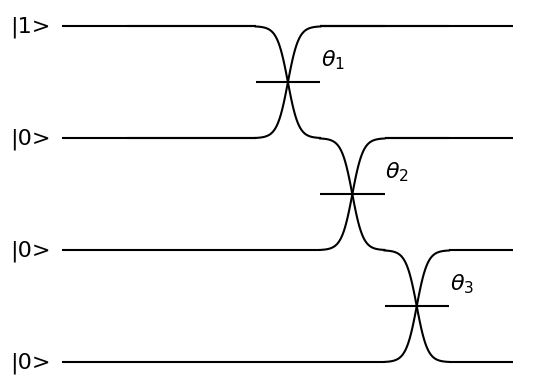

In [ ]:
tbi.draw(input_state=(1,0,0,0))

The following cell iterates over the states and looks at the measured detection rates for each case. Then it compares these with the acceptance thresholds provided above.

In [ ]:
N_MIN_PHOTON = 1
N_MAX_PHOTON = 5

for n_photons in np.arange(N_MIN_PHOTON,N_MAX_PHOTON+1):

    # create tbi to apply postselecttion appropriately
    qd_tbi_params['postselection_threshold'] = int(n_photons)
    tbi = create_tbi(**qd_tbi_params)  # SDK version 2.5.6 or greater

    input_state = tuple([1]*n_photons*2)
    theta_list = [0]*(n_photons*2-1)
    
    output = estimate_statistics(
        tbi = tbi,
        input_state = input_state,
        theta_list = theta_list,
        n_samples = N_SAMPLES[n_photons],
        overhead_time_with_margin = overhead_time_with_margin
    )

    n_samples_collected = output[0]
    rates = output[1]
    accuracy = output[2]
    request_time = output[3]
    samples = output[4]

    if n_photons == 1:
        samples_1_photons = samples

    print(f"============= {n_photons} Photon Data ======================")
    print(f"Input state: {input_state}")
    print(f"{n_samples_collected} samples collected in {request_time:.2f} seconds")
    print(f"{n_photons} photon rate is {rates:.3f} Hz")

    if rates > acceptance_targets[f"ACCEPTANCE_RATES_{n_photons}_PHOTON"]:
        print(f"Acceptance test passed for {n_photons} photon rate: PASS")
    else:
        print(f"Acceptance test passed for {n_photons} photon rate: FAIL")

    # if f"ACCEPTANCE_ACCURACY_{n_photons}_PHOTON" in acceptance_targets.keys():
    #     print(f"{n_photons} photon accuracy is {accuracy:.3f} ")
    #     if accuracy > acceptance_targets[f"ACCEPTANCE_ACCURACY_{n_photons}_PHOTON"]:
    #         print(f"Acceptance test passed for {n_photons} photon accuracy: PASS")
    #     else:
    #         print(f"Acceptance test passed for {n_photons} photon accuracy: FAIL")
    
    print("\n")

============= 1 Photon Data ======================
Input state: (1, 1)
10000 samples collected in 2.56 seconds
1 photon rate is 3901.217 Hz
Acceptance test passed for 1 photon rate: PASS


============= 2 Photon Data ======================
Input state: (1, 1, 1, 1)
2000 samples collected in 6.57 seconds
2 photon rate is 304.367 Hz
Acceptance test passed for 2 photon rate: PASS


============= 3 Photon Data ======================
Input state: (1, 1, 1, 1, 1, 1)
200 samples collected in 6.56 seconds
3 photon rate is 30.484 Hz
Acceptance test passed for 3 photon rate: PASS


============= 4 Photon Data ======================
Input state: (1, 1, 1, 1, 1, 1, 1, 1)
50 samples collected in 29.86 seconds
4 photon rate is 1.675 Hz
Acceptance test passed for 4 photon rate: FAIL


============= 5 Photon Data ======================
Input state: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
20 samples collected in 115.03 seconds
5 photon rate is 0.174 Hz
Acceptance test passed for 5 photon rate: FAIL




## A1.2 One photon routing acceptance test
Sending input state [1,0,0,0] and all beam splitters to pi/2, this will route the photon from the first qumode to the last qumode in the sample. We measure how often we get target state [0,0,0,1]

============= Photon Routing Data ======================
Photon routing accuracy is 94 %


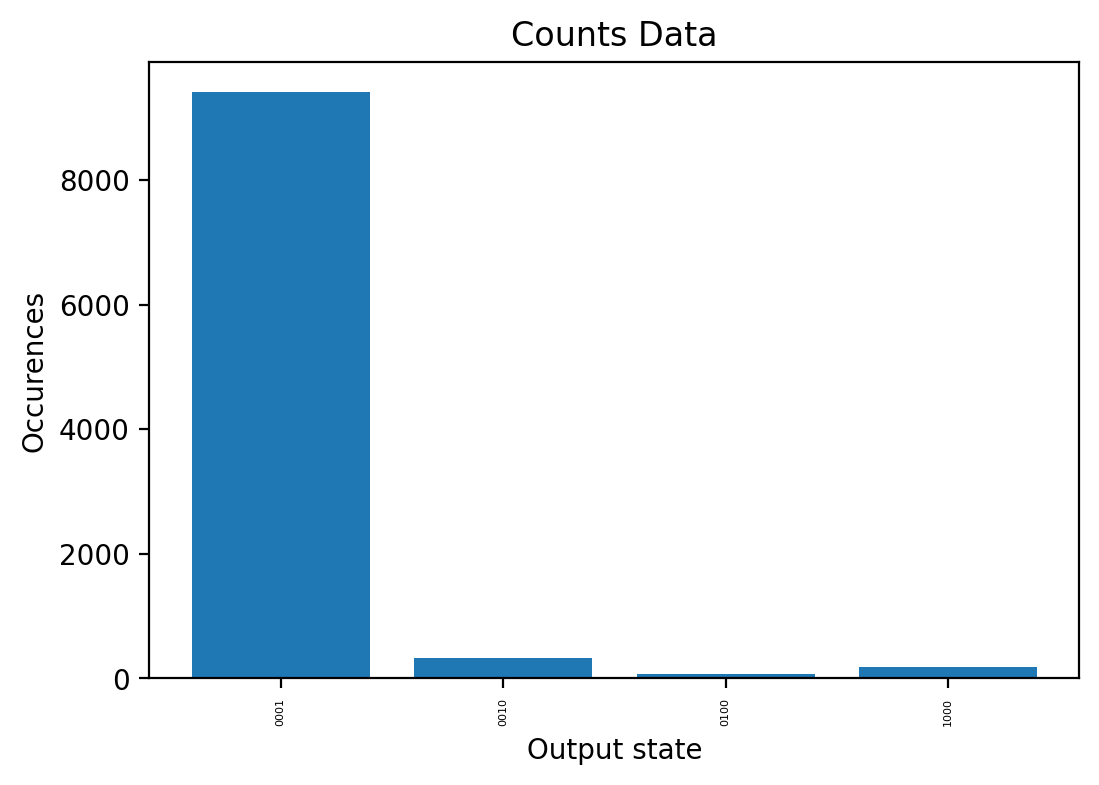

In [ ]:
qd_tbi_params['postselection_threshold'] = None
tbi = create_tbi(**qd_tbi_params)  # SDK version 2.5.6 or greater
samples_routing = tbi.sample(
    input_state=(1, 0, 0, 0), theta_list=3 * [np.pi / 2], n_samples=N_SAMPLES[1]  # Sets all circuit elements to swap
)

n_samples_routing = sum(samples_routing.values())
n_target_samples = samples_routing.get((0,0,0,1), 0)
routing_accuracy = 100*n_target_samples/n_samples_routing

print("============= Photon Routing Data ======================")
print(f"Photon routing accuracy is {routing_accuracy:.0f} %")
plot(samples_routing)

In [ ]:
if routing_accuracy > acceptance_targets["ACCEPTANCE_ACCURACY_1_PHOTON_ROUTING"]:
    print("Acceptance test passed for 1 photon routing accuracy: PASS")
else:
    print("Acceptance test passed for 1 photon routing accuracy: FAIL")

Acceptance test passed for 1 photon routing accuracy: PASS


# A2 Heralded Single Photon Source Acceptance Tests
The following cells will test the performance of the Heralded single-photon source light source Boson Sampling System.

In [ ]:
tbi = create_tbi(**hsps_tbi_params)  # SDK version 2.5.6 or greater
acceptance_targets = hsps_acceptance_targets

This cell runs a single sample request for 1 photon. This eliminates any overheads due to re-calibration of the quantum processors or just in time compilation.

In [22]:
tbi.sample(input_state=(1,0, 0), theta_list=[0, 0, 0, 0], n_samples=100)

{(0, 1, 0): 2, (1, 0, 0): 98}

The following cell estimates any additional overheads for sampling jobs, which we account for in our rates calculations

In [23]:
start_time = time.time()
tbi.sample(input_state=(1, 0,0), theta_list=[0,0,0,0], n_samples=10)
overhead_time = time.time() - start_time
overhead_time_with_margin = max([overhead_time - 1, 0])

print(f"Overhead time for SMSV sampling is {overhead_time:.2f}s")
print(f"Reducing to {overhead_time_with_margin:.2f}s to leave a margin of error")

Overhead time for SMSV sampling is 0.66s
Reducing to 0.00s to leave a margin of error


## A3.1 Photon rate and accuracy acceptance tests

All the acceptance tests run using the circuit below, shown here with a 1000 input state.

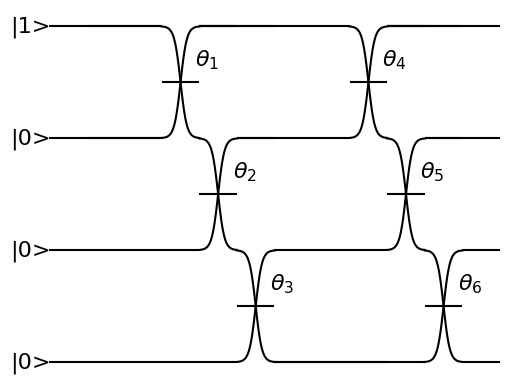

In [24]:
tbi.draw(input_state=(1,0,0,0))

The following cell iterates over the states and looks at the measured detection rates for each case. Then it compares these with the acceptance thresholds provided above.

In [ ]:
N_MIN_PHOTON = 1
N_MAX_PHOTON = 4


print(f"CURRENT TIME: {get_date_as_string()}")

for n_photons in np.arange(N_MIN_PHOTON,N_MAX_PHOTON+1):

    # create tbi to apply postselecttion appropriately
    hsps_tbi_params['postselection_threshold'] = None
    tbi = create_tbi(**hsps_tbi_params)  # SDK version 2.5.6 or greater

    qumodes = 4
    input_state = tuple([1]*n_photons+[0]*(qumodes-n_photons))
    theta_list = [0]*(qumodes-1)*2
    
    output = estimate_statistics(
        tbi = tbi,
        input_state = input_state,
        theta_list = theta_list,
        n_samples = N_SAMPLES[n_photons]*10,
        overhead_time_with_margin = overhead_time_with_margin
    )

    n_samples_collected = output[0]
    rates = output[1]
    accuracy = output[2]
    request_time = output[3]
    samples = output[4]

    if n_photons == 1:
        samples_1_photons = samples

    print(f"============= {n_photons} Photon Data ======================")
    print(f"Input state: {input_state}")
    print(f"{n_samples_collected} samples collected in {request_time:.2f} seconds")
    print(f"{n_photons} photon rate is {rates:.3f} Hz")

    if rates > acceptance_targets[f"ACCEPTANCE_RATES_{n_photons}_PHOTON"]:
        print(f"Acceptance test passed for {n_photons} photon rate: PASS")
    else:
        print(f"Acceptance test passed for {n_photons} photon rate: FAIL")

    # if f"ACCEPTANCE_ACCURACY_{n_photons}_PHOTON" in acceptance_targets.keys():
    #     print(f"{n_photons} photon accuracy is {accuracy:.3f} ")
    #     if accuracy > acceptance_targets[f"ACCEPTANCE_ACCURACY_{n_photons}_PHOTON"]:
    #         print(f"Acceptance test passed for {n_photons} photon accuracy: PASS")
    #     else:
    #         print(f"Acceptance test passed for {n_photons} photon accuracy: FAIL")
    
    print("\n")

CURRENT TIME: 2025-03-20_16-48-13
============= 1 Photon Data ======================
Input state: (1, 0, 0, 0)
100000 samples collected in 123.82 seconds
1 photon rate is 807.644 Hz
Acceptance test passed for 1 photon rate: PASS


============= 2 Photon Data ======================
Input state: (1, 1, 0, 0)
20000 samples collected in 1867.66 seconds
2 photon rate is 10.709 Hz
Acceptance test passed for 2 photon rate: FAIL




ConnectionError: HTTPConnectionPool(host='192.168.22.198', port=8080): Max retries exceeded with url: /v1/get_job/2d5ff84c-7701-4e0e-8da5-b253654ce919 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000023D5988E6F0>: Failed to establish a new connection: [WinError 10051] A socket operation was attempted to an unreachable network'))

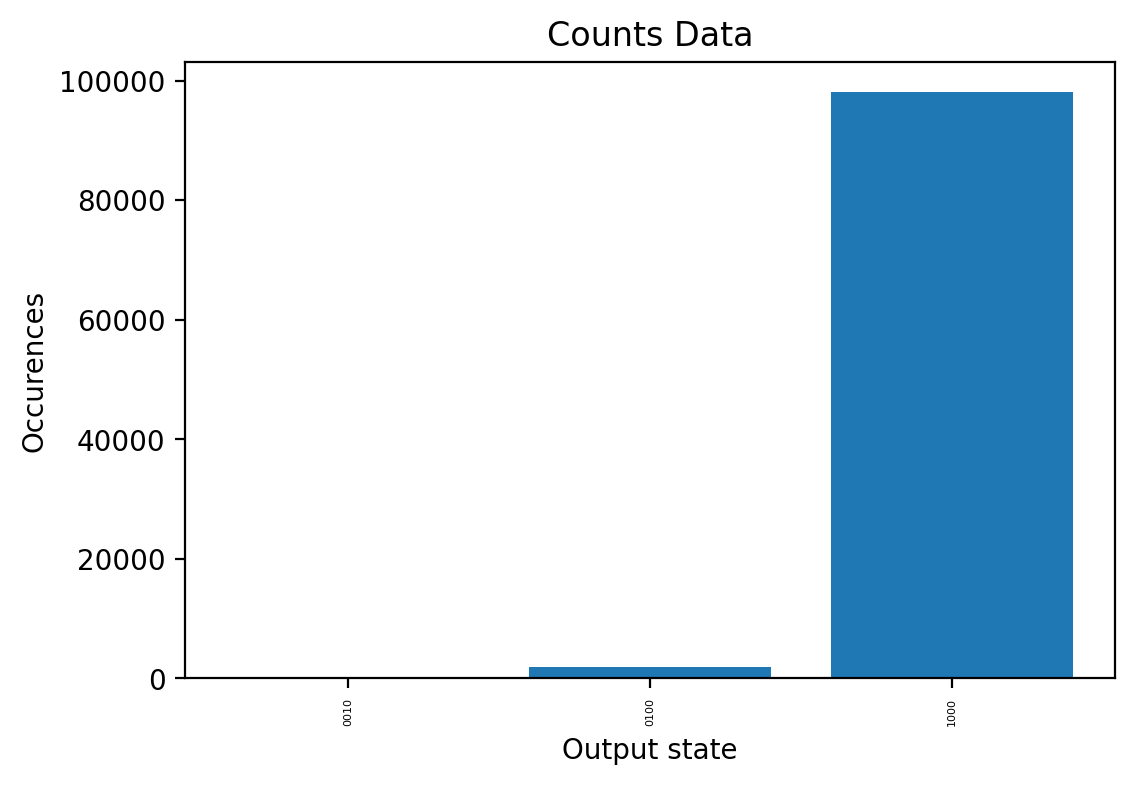

In [12]:
plot(samples_1_photons)

## A1.2 One photon routing acceptance test
Sending input state [1,0,0,0] and all beam splitters to pi/2, this will route the photon from the first qumode to the last qumode in the sample. We measure how often we get target state [0,0,0,1]

============= Photon Routing Data ======================
Photon routing accuracy is 96 %


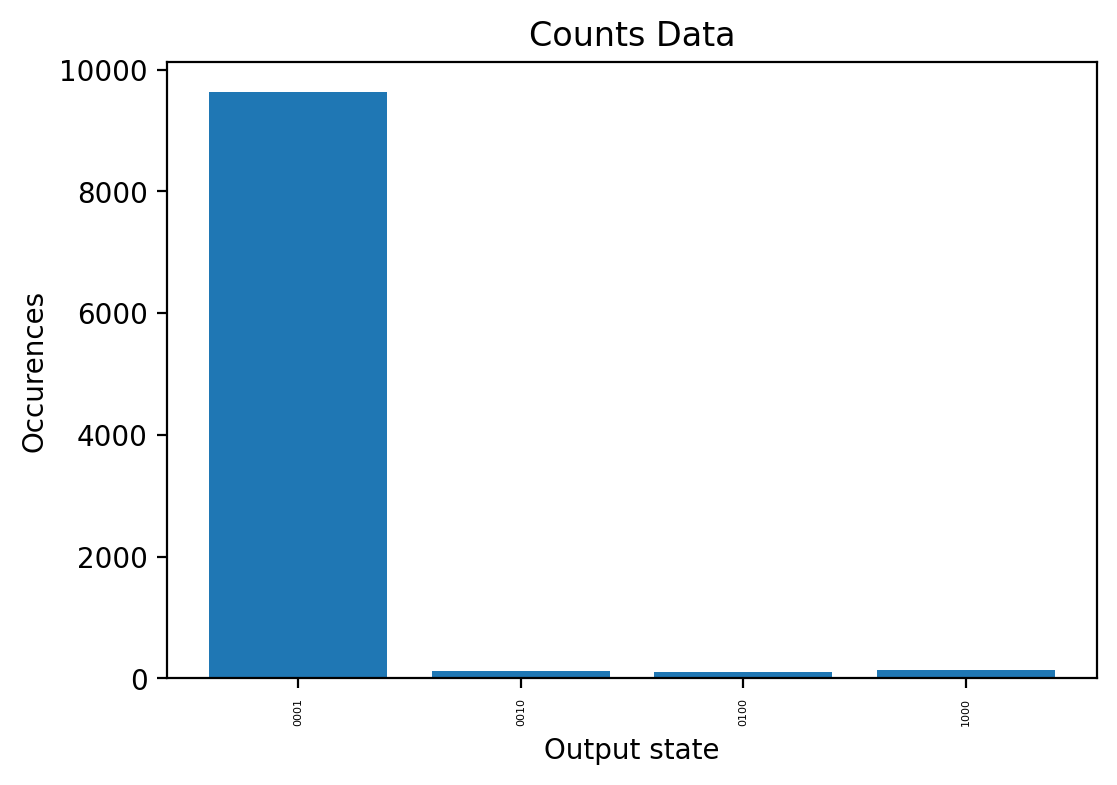

In [13]:
hsps_tbi_params['postselection_threshold'] = None
tbi = create_tbi(**hsps_tbi_params)  # SDK version 2.5.6 or greater
samples_routing = tbi.sample(
    input_state=(1, 0, 0, 0), theta_list=3 * [np.pi / 2] +3* [0], n_samples=N_SAMPLES[1]  # Sets all circuit elements to swap
)

n_samples_routing = sum(samples_routing.values())
n_target_samples = samples_routing.get((0,0,0,1), 0)
routing_accuracy = 100*n_target_samples/n_samples_routing

print("============= Photon Routing Data ======================")
print(f"Photon routing accuracy is {routing_accuracy:.0f} %")
plot(samples_routing)

In [14]:
if routing_accuracy > acceptance_targets["ACCEPTANCE_ACCURACY_1_PHOTON_ROUTING"]:
    print("Acceptance test passed for 1 photon routing accuracy: PASS")
else:
    print("Acceptance test passed for 1 photon routing accuracy: FAIL")

KeyError: 'ACCEPTANCE_ACCURACY_1_PHOTON_ROUTING'

# A3: SMSV Acceptance Test

In [ ]:
tbi = create_tbi(**gbs_tbi_params)  # SDK version 2.5.6 or greater
acceptance_targets = smsv_acceptance_targets

This cell runs a single sample request for 1 photon. This eliminates any overheads due to re-calibration of the quantum processors or just in time compilation. 

Here, moreover, after running the sample command we will pause for a couple of minutes for the system to optimise the new source settings.

In [ ]:
tbi.sample(input_state=(1,0, 0), theta_list=[0, 0, 0, 0], n_samples=100,)
print("Waiting for 2 minutes to let the system get to an optimal state after swapping sources!")
time.sleep(120)

{(0, 1, 0): 3, (1, 0, 0): 97}

The following cell estimates any additional overheads for sampling jobs, which we account for in our rates calculations

In [8]:
start_time = time.time()
tbi.sample(input_state=(1, 0,0), theta_list=[0,0,0,0], n_samples=10)
overhead_time = time.time() - start_time
overhead_time_with_margin = max([overhead_time - 1, 0])

print(f"Overhead time for SMSV sampling is {overhead_time:.2f}s")
print(f"Reducing to {overhead_time_with_margin:.2f}s to leave a margin of error")

Overhead time for SMSV sampling is 0.48s
Reducing to 0.00s to leave a margin of error


## A3.1 Photon rate and accuracy acceptance tests

All the acceptance tests run using the circuit below, shown here with a 1000 input state.

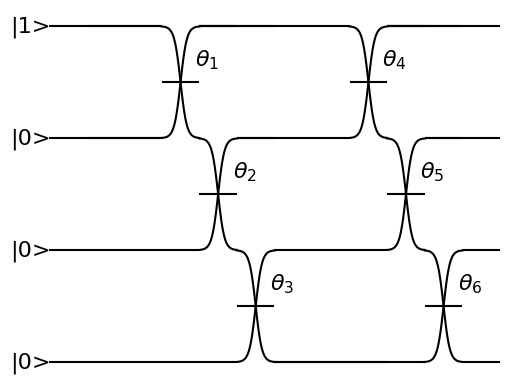

In [9]:
tbi.draw(input_state=(1,0,0,0))

The following cell iterates over the states and looks at the measured detection rates for each case. Then it compares these with the acceptance thresholds provided above.

In [10]:
N_MIN_PHOTON = 1
N_MAX_PHOTON = 5

for n_photons in np.arange(N_MIN_PHOTON,N_MAX_PHOTON+1):

    # create tbi to apply postselecttion appropriately
    gbs_tbi_params['postselection_threshold'] = int(n_photons)
    tbi = create_tbi(**gbs_tbi_params)  # SDK version 2.5.6 or greater

    qumodes = n_photons*2
    input_state = tuple([1]*qumodes)
    theta_list = [0]*(qumodes-1)*2
    
    output = estimate_statistics(
        tbi = tbi,
        input_state = input_state,
        theta_list = theta_list,
        n_samples = N_SAMPLES[n_photons]*10,
        overhead_time_with_margin = overhead_time_with_margin
    )

    n_samples_collected = output[0]
    rates = output[1]
    accuracy = output[2]
    request_time = output[3]
    samples = output[4]

    if n_photons == 1:
        samples_1_photons = samples

    print(f"============= {n_photons} Photon Data ======================")
    print(f"Input state: {input_state}")
    print(f"{n_samples_collected} samples collected in {request_time:.2f} seconds")
    print(f"{n_photons} photon rate is {rates:.3f} Hz")

    if rates > acceptance_targets[f"ACCEPTANCE_RATES_{n_photons}_PHOTON"]:
        print(f"Acceptance test passed for {n_photons} photon rate: PASS")
    else:
        print(f"Acceptance test passed for {n_photons} photon rate: FAIL")

    # if f"ACCEPTANCE_ACCURACY_{n_photons}_PHOTON" in acceptance_targets.keys():
    #     print(f"{n_photons} photon accuracy is {accuracy:.3f} ")
    #     if accuracy > acceptance_targets[f"ACCEPTANCE_ACCURACY_{n_photons}_PHOTON"]:
    #         print(f"Acceptance test passed for {n_photons} photon accuracy: PASS")
    #     else:
    #         print(f"Acceptance test passed for {n_photons} photon accuracy: FAIL")
    
    print("\n")

============= 1 Photon Data ======================
Input state: (1, 1)
100000 samples collected in 6.17 seconds
1 photon rate is 16218.510 Hz
Acceptance test passed for 1 photon rate: PASS


============= 2 Photon Data ======================
Input state: (1, 1, 1, 1)
20000 samples collected in 3.71 seconds
2 photon rate is 5388.033 Hz
Acceptance test passed for 2 photon rate: PASS


============= 3 Photon Data ======================
Input state: (1, 1, 1, 1, 1, 1)
2000 samples collected in 1.30 seconds
3 photon rate is 1536.601 Hz
Acceptance test passed for 3 photon rate: PASS


============= 4 Photon Data ======================
Input state: (1, 1, 1, 1, 1, 1, 1, 1)
500 samples collected in 0.94 seconds
4 photon rate is 533.001 Hz
Acceptance test passed for 4 photon rate: PASS


============= 5 Photon Data ======================
Input state: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
200 samples collected in 0.65 seconds
5 photon rate is 310.028 Hz
Acceptance test passed for 5 photon rate: PASS




In [12]:
plot(samples_1_photons)

NameError: name 'plt' is not defined

## A1.2 One photon routing acceptance test
Sending input state [1,0,0,0] and all beam splitters to pi/2, this will route the photon from the first qumode to the last qumode in the sample. We measure how often we get target state [0,0,0,1]

In [13]:
gbs_tbi_params['postselection_threshold'] = None
tbi = create_tbi(**gbs_tbi_params)  # SDK version 2.5.6 or greater
samples_routing = tbi.sample(
    input_state=(1, 0, 0, 0), theta_list=3 * [np.pi / 2] +3* [0], n_samples=N_SAMPLES[1]  # Sets all circuit elements to swap
)

n_samples_routing = sum(samples_routing.values())
n_target_samples = samples_routing.get((0,0,0,1), 0)
routing_accuracy = 100*n_target_samples/n_samples_routing

print("============= Photon Routing Data ======================")
print(f"Photon routing accuracy is {routing_accuracy:.0f} %")
plot(samples_routing)

============= Photon Routing Data ======================
Photon routing accuracy is 98 %


NameError: name 'plt' is not defined